

<h1 align="center">Navigating the Allen Brain Observatory</h1> 
<h3 align="center">Cosyne Tutorial</h3>
<h3 align="center">Thursday, February 28,2019</h3> 

This notebook walks us through how to use the Allen SDK to access data.  We will compute basic tuning curves and compare responses across cells within the same experiment.


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">

<h1> Part 1: Imports and set up</h1>

</div>

### Standard Imports

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline  
import os

An additional import that we'll use later in the notebook

In [ ]:
import scipy.stats as st

### Brain Observatory set up

In [2]:
from allensdk.core.brain_observatory_cache import BrainObservatoryCache
drive_path = '/data/allen-brain-observatory/visual-coding-2p'
manifest_file = os.path.join(drive_path,'manifest.json')

boc = BrainObservatoryCache(manifest_file=manifest_file)

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">

<h1>Part 2: Compute the tuning curve for the drifting grating stimulus</h1>

Each of you received a cell specimen id, a unique 9 digit number specific to a single neuron in the dataset. We are going to start by computing the tuning curve for this neuron in response to the drifting grating. 

</div>

Enter the your unique cell specimen id for the variable cell_id

In [162]:
cell_id = 541513979

First get the dataset for the **experiment session** that this cell is in that has the drifting grating stimulus

In [140]:
exps = boc.get_ophys_experiments(cell_specimen_ids=[cell_id], stimuli=['drifting_gratings'])
session_id = exps[0]['id']
data_set = boc.get_ophys_experiment_data(session_id)

Get the DF/F trace for your cell. For now we just want to think about your one cell, so just get the trace for your cell.

In [61]:
timestamps, dff = data_set.get_dff_traces(cell_specimen_ids=[cell_id])
dff_trace = dff[0,:]

In [62]:
dff.shape

(1, 115741)

Let's plot the DF/F trace of our cell to see what it looks like

Text(0,0.5,'DFF')

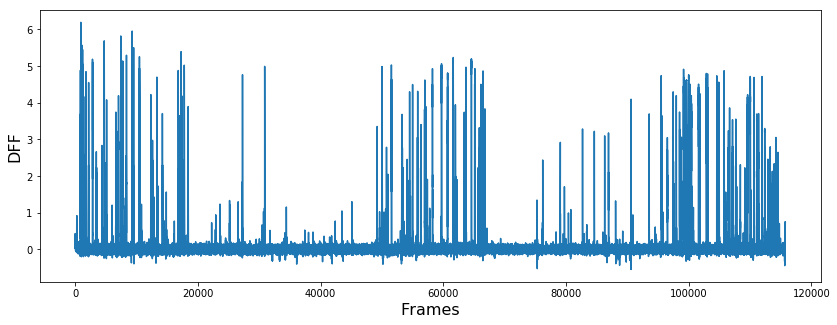

In [95]:
plt.figure(figsize=(14,5))
plt.plot(dff_trace)
plt.xlabel("Frames", fontsize=16)
plt.ylabel("DFF", fontsize=16)

Get the stimulus table for the drifting grating stimulus

In [ ]:
stim_table = data_set.get_stimulus_table('drifting_gratings')

Let's look at the stimulus table to see what information there is. This is a Pandas DataFrame (see box below). You just want to see the first few lines, so use the function <b>head</b> to see the top of this DataFrame.

In [64]:
stim_table.head()

,temporal_frequency,orientation,blank_sweep,start,end
0,1.0,45.0,0.0,736,796
1,15.0,90.0,0.0,826,886
2,1.0,270.0,0.0,917,977
3,NaN,NaN,1.0,1007,1067
4,4.0,90.0,0.0,1098,1158


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
The stimulus table has 5 columns.  Start and end indicate the <b>imaging frame number</b> when a given trial starts and ends, respectively. The other columns indicate what the grating codition is for that trial, including the temporal frequency of the grating (in Hz), the direction (called orientation) of the grating (in degrees), and whether the grating is a blank sweep (eg. a gray screen). 
</div>

<div style="border-radius: 3px; padding: 10px;  background: #F0FAFF; ">

## Quick Pandas tutorial for our purposes today
<p>
Pandas is a very useful Python module for data analysis, which has an object called a <b>DataFrame</b> that is a flexible and powerful tool for analyzing large datasets. There is some information below for those who aren't familiar with Pandas.
    
To access data from a DataFrame we must specify the column we are using and specify the row using the <b>index</b>. To specify a column we can use two methods:
<li> stim_table['start']
<li> stim_table.start
<p> Then to specify the row we want we must use the index of that row. 
<li> stim_table['start'][0]
<li> stim_table.start[0]
<p> We can also subselect portions of the DataFrame using the values in the DataFrame. For example, to select only the rows of the table where the orientation is 90 degrees we can use:
<li> stim_table[stim_table.orientation==90]
<p>Try this yourself.  Note the index.  The rows of this subselected DataFrame maintain the indices of the original DataFrame. Now in order to get a specific row, you either need to know it's original index, or use <b>iloc</b>. For example, this will return the first row of the subselected DataFrame regardless of the original index of that row:
<li> stim_table[stim_table.orientation==90].iloc[0]
</div>

To look at the cell's response to a given grating presentation, let's plot the DF/F of the cell during the presentation of that grating.  We want to pad the plot with ~ 1 second of the DF/F trace preceding the grating presentation.  1 second = 30 frames.  We'll plot the response to the first grating presentation. Print the grating direction and temporal frequency as well.

Direction:  45.0
Temporal frequency:  1.0


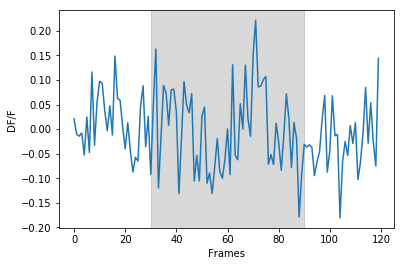

In [189]:
plt.plot(dff_trace[stim_table.start[0]-30:stim_table.end[0]+30])


plt.axvspan(30,90, color='gray', alpha=0.3) #this shades the period when the stimulus is being presented
plt.ylabel("DF/F")
plt.xlabel("Frames")

print "Direction: ", stim_table.orientation[0]
print "Temporal frequency: ", stim_table.temporal_frequency[0]

Quantify this response by calculating the mean DF/F during the grating presentation

In [190]:
dff_trace[stim_table.start[0]:stim_table.end[0]].mean()

-0.0020014683


Repeat this (the plot and the quantification) for the next grating stimulus

Direction:  90.0
Temporal frequency:  15.0


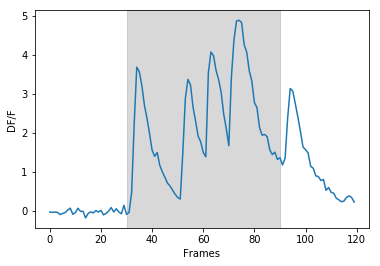

In [191]:
plt.plot(dff_trace[stim_table.start[1]-30:stim_table.end[1]+30])
plt.axvspan(30,90, color='gray', alpha=0.3) #this shades the period when the stimulus is being presented
plt.ylabel("DF/F")
plt.xlabel("Frames")

print "Direction: ", stim_table.orientation[1]
print "Temporal frequency: ", stim_table.temporal_frequency[1]

In [192]:
dff_trace[stim_table.start[1]:stim_table.end[1]].mean()

2.292613

<div style="background: ##DFF0D8; border-radius: 3px; padding: 10px;">

<p>Calculate the mean DF/F for each grating presentation in this stimulus. 
Create a numpy array to hold our calculated responses with three columns, one for the stimulus orientation, one for temporal frequency, and the last for the response. Then we need to iterate over all stimulus trials, populate the orientation and TF and then calculate the mean response.
</div>

In [65]:
cell_response= np.zeros((len(stim_table),3))
for i in range(len(stim_table)):
    cell_response[i,0] = stim_table.orientation[i]
    cell_response[i,1] = stim_table.temporal_frequency[i]
    cell_response[i,2] = dff_trace[stim_table.start[i]:stim_table.end[i]].mean()

You need to know what all the possible orientation values are. You can either find this from the website, white paper documentation, platform paper preprint ... or you can find the <b>unique</b> values that are not NaNs (eg. values that are <b>finite</b>) from either the stimulus table or the columns you just set up in the array.


In [193]:
all_ori = np.unique(cell_response[:,0])
orivals = all_ori[np.isfinite(all_ori)]
print orivals

[  0.  45.  90. 135. 180. 225. 270. 315.]


In [196]:
np.sort(stim_table.orientation.dropna().unique())

array([  0.,  45.,  90., 135., 180., 225., 270., 315.])

In [67]:
tfvals = np.unique(cell_response[:,1])
tfvals = tfvals[np.isfinite(tfvals)]
print tfvals

[ 1.  2.  4.  8. 15.]


Create an array of the mean response of your neuron to each grating condition, size (8,5) for orientation X temporal frequency

In [208]:
tuning_array = np.empty((8,5))
for i,ori in enumerate(orivals):
    for j,tf in enumerate(tfvals):
        trials = np.where(np.logical_and(cell_response[:,0]==ori, cell_response[:,1]==tf))[0]
        tuning_array[i,j] = cell_response[trials,2].mean()
      

Plot the orientation tuning at each temporal frequency

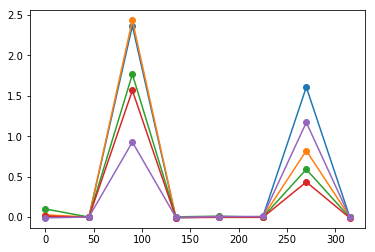

In [29]:
for i in range(5):
    plt.plot(orivals, tuning_array[:,i], 'o-')

Plot the temporal frequency tuning at each orientation

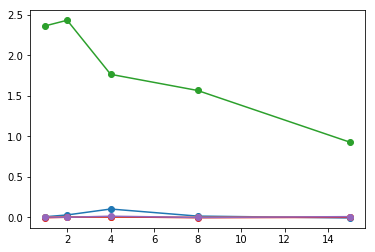

In [30]:
for i in range(5):
    plt.plot(tfvals, tuning_array[i,:], 'o-')

Plot a heatmap of the responses to all conditions

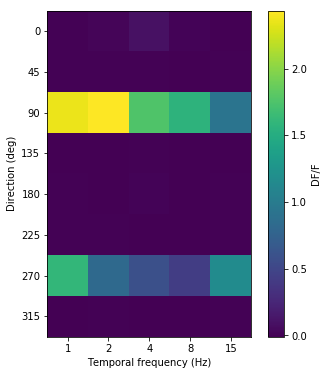

In [219]:
fig = plt.figure(figsize=(6,6))
plt.imshow(tuning_array)
plt.xticks(range(5), tfvals.astype(int))
plt.yticks(range(8), orivals.astype(int))
plt.xlabel("Temporal frequency (Hz)")
plt.ylabel("Direction (deg)")
cbar = plt.colorbar()
cbar.set_label("DF/F")

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">

<h1> Part 3: Compute and compare the tuning for all cells in this experiment</h1>

Now we are going to compute the same tuning curve for all of the cells in your experiment, and compare how similar they are with each other by computing the signal correlation.
</div>

Get the DF/F traces for all of neurons in the dataset. Previously we only got one trace, now we want them all.

In [228]:
timestamps, dff = data_set.get_dff_traces()

How many neurons are in the dataset? This will be a useful variable later. Call it **numbercells**

In [229]:
numbercells = dff.shape[0]
print numbercells

290


Write a function to create an array with dimensions (8,5,numbercells) with the mean response to each condition for each cell in your experiment.

In [230]:
def compute_tuning_all_cells(dff, stim_table):
    numbercells = dff.shape[0]
    response = np.empty((8,5,numbercells))
    mean_sweep_response = pd.DataFrame(index=stim_table.index.values, columns=np.array(range(numbercells)).astype(str))
    for index, row in stim_table.iterrows():
        mean_sweep_response.loc[index] = dff[:,int(row.start):int(row.end)].mean(axis=1)
    for i,ori in enumerate(orivals):
        for j,tf in enumerate(tfvals):
            subset = mean_sweep_response[(stim_table.orientation==ori)&(stim_table.temporal_frequency==tf)]
            response[i,j,:] = subset.mean(axis=0).values
    return response

In [231]:
response = compute_tuning_all_cells(dff, stim_table)

Confirm your function by plotting the mean response for the cell that you used above. You need to find the cell index for your cell. Use data_set.get_cell_specimen_indices to find the index for that cell.

In [232]:
cell_index = data_set.get_cell_specimen_indices(cell_specimen_ids=[cell_id])[0]
print cell_index

6


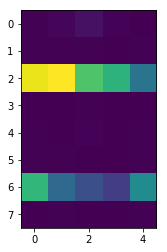

In [233]:
plt.imshow(response[:,:,cell_index])

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">

Compute the signal correlations (the Pearson correlation between mean responses) between all of the cells in your dataset. Use the scipy.stats **pearsonr** function to compute this

</div>

In [234]:
signal_correlations = np.empty((numbercells, numbercells))
signal_correlations[:] = np.NaN
for i in range(numbercells):
    for j in range(numbercells):
        if j>i:
            r,p = st.pearsonr(response[:,:,i].flatten(), response[:,:,j].flatten())
            signal_correlations[i,j] = r

What is the mean signal correlations across all the cells in your experiment?

In [235]:
np.nanmean(signal_correlations)

0.25423116283754355

<div style="background: #FFF0F0; border-radius: 3px; padding: 10px;">
Report the mean signal correlation for your dataset using this google form:

https://goo.gl/forms/y63VroJasCc1lB6X2

Include the following metadata:
* which visual area is the data recorded in?
* which Cre line is it from?
* at what imaging depth was the data collected
* what is the age (in days) of the mouse when the data was collected?
* what is the sex of the mouse
* how many neurons were imaged?

In [120]:
data_set.get_metadata()

{'age_days': 121,
 'cre_line': u'Emx1-IRES-Cre/wt',
 'device': u'Nikon A1R-MP multiphoton microscope',
 'device_name': u'CAM2P.1',
 'excitation_lambda': u'910 nanometers',
 'experiment_container_id': 536323956,
 'fov': u'400x400 microns (512 x 512 pixels)',
 'genotype': u'Emx1-IRES-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-GCaMP6f)/wt',
 'imaging_depth_um': 175,
 'indicator': u'GCaMP6f',
 'ophys_experiment_id': 540684467,
 'pipeline_version': u'3.0',
 'session_start_time': datetime.datetime(2016, 8, 23, 11, 45, 14),
 'session_type': u'three_session_A',
 'sex': u'male',
 'specimen_name': u'Emx1-IRES-Cre;Camk2a-tTA;Ai93(MG)-252174',
 'targeted_structure': u'VISp'}

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">

Find the cell that has the highest correlation with your cell. Plot its tuning curve. How is it similar? How is it different?

</div>

The correlation matrix we made above was just the upper triangle. Fill out the entire matrix in order to find the maximum correlation for your cell

In [236]:
signal_correlations[np.isnan(signal_correlations)]=0
signal_correlations_full = signal_correlations+signal_correlations.T

In [237]:
cell_index_2 = signal_correlations_full[cell_index,:].argmax()
print cell_index_2

56


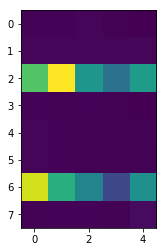

In [238]:
plt.imshow(response[:,:,cell_index_2])

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">

<h1> Part 4: Other stimuli in this session</h1>

Drifting gratings isn't the only stimulus presented during this session. Find what other stimuli were also presented
</div>

In [121]:
data_set.get_stimulus_epoch_table()

,stimulus,start,end
0,drifting_gratings,736,18810
1,natural_movie_three,19746,37850
2,natural_movie_one,38756,47807
3,drifting_gratings,48712,66786
4,spontaneous,66936,75868
5,natural_movie_three,75869,93972
6,drifting_gratings,94878,115485


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">

<h1> Part 5: Correlations of movie responses </h1>

We will compute the correlation of the responses to natural movie three across neurons to compare with the drifting gratings.
</div>

The DF/F traces we have are for the entire session, so we already have that. But we need the stimulus table for the natural movie.

In [176]:
stim_table_nm3 = data_set.get_stimulus_table('natural_movie_three')

In [177]:
stim_table_nm3.head()

,frame,start,end,repeat
0,0,19746,19747,0
1,1,19747,19748,0
2,2,19748,19749,0
3,3,19749,19750,0
4,4,19750,19751,0


How many frames are in the natural movie? How many repeats? How long does each frame (typically) last? (why might it vary from this?) 

In [239]:
num_frames = len(stim_table_nm3.frame.unique())
print num_frames

3600


In [240]:
num_repeats = len(stim_table_nm3.repeat.unique())
print num_repeats

10


Out of curiosity, let's look at the first and the last frame of the movie. Get the stimulus template for this movie and plot the first and the last frame of the movie.

In [127]:
template = data_set.get_stimulus_template('natural_movie_three')

In [128]:
template.shape

(3600, 304, 608)

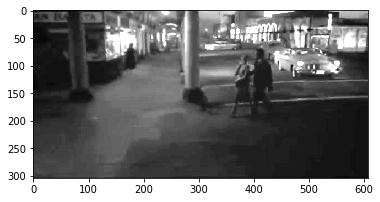

In [129]:
plt.imshow(template[0,:,:], cmap='gray')

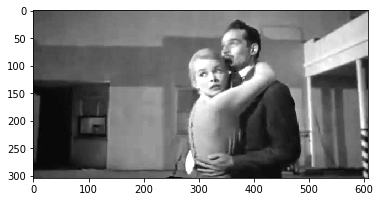

In [130]:
plt.imshow(template[-1,:,:], cmap='gray')

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">

Compute the mean response for each neuron to the movie.  

</div>

In [241]:
response_nm3 = np.empty((numbercells, num_frames))
temp = np.empty((numbercells, num_frames, num_repeats))
for i in range(num_repeats):
    start_time = int(stim_table_nm3[(stim_table_nm3.frame==0)&(stim_table_nm3.repeat==i)].start)
    temp[:,:,i] = dff[:, start_time:start_time+num_frames]
response_nm3 = temp.mean(axis=2)

Plot the mean movie response for the cell you analyzed above

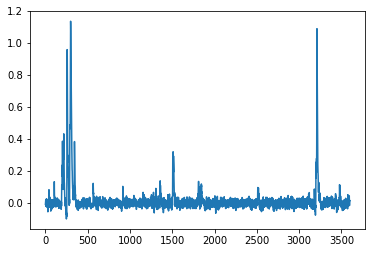

In [242]:
plt.plot(response_nm3[cell_index,:])

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">

Compute the correlation of mean movie response for all neurons

</div>


In [180]:
movie_correlations = np.empty((numbercells, numbercells))
movie_correlations[:] = np.NaN
for i in range(numbercells):
    for j in range(numbercells):
        if j>i:
            r,p = st.pearsonr(response_nm3[i,:], response_nm3[j,:])
            movie_correlations[i,j] = r

What is the mean correlations across all the cells in your experiment?

In [181]:
np.nanmean(movie_correlations)

0.07977039598639278

<div style="background: #FFF0F0; border-radius: 3px; padding: 10px;">

Report this mean correlation at this google form: https://goo.gl/forms/zj3xnhhySalayTA83

Which neuron has the highest correlation with your neuron for the natural movie? Is it the same neuron as for the drifting gratings? Plot both of their movie responses.

In [182]:
movie_correlations[np.isnan(movie_correlations)]=0

test = movie_correlations+movie_correlations.T
plt.imshow(test)

In [186]:
print test[6,:].argmax()

56


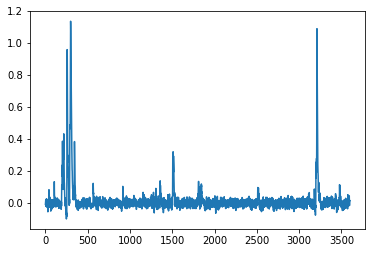

In [187]:
plt.plot(response_nm3[6,:])

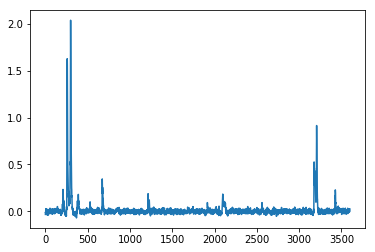

In [188]:
plt.plot(response_nm3[56,:])

# The end

Extra time? For the two cells you have (your cell and the cell that it has its strongest movie correlation with) calculate the distance between these two cells.

In [243]:
rois = data_set.get_roi_mask_array()

In [244]:
rois.shape

(290, 512, 512)

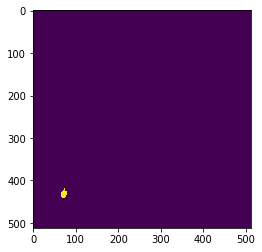

In [252]:
plt.imshow(rois[cell_index,:,:])

In [247]:
x_mean = np.where(rois[cell_index,:,:]>0)[0].mean()
y_mean = np.where(rois[cell_index,:,:]>0)[1].mean()
print x_mean, y_mean

431.06060606060606 71.87012987012987


In [248]:
x_mean_2 = np.where(rois[cell_index_2,:,:]>0)[0].mean()
y_mean_2 = np.where(rois[cell_index_2,:,:]>0)[1].mean()
print x_mean_2, y_mean_2

411.0934959349593 51.90650406504065


In [249]:
print np.sqrt(((x_mean-x_mean_2)**2)+((y_mean-y_mean_2)**2))

28.235294261886644


Even more extra time? Plot the max projection with your two ROIs highlighted.

In [253]:
max_projection = data_set.get_max_projection()

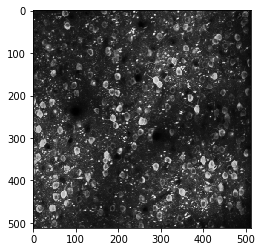

In [255]:
plt.imshow(max_projection, cmap='gray')

In [270]:
two_rois = rois[cell_index,:,:]+rois[cell_index_2,:,:]

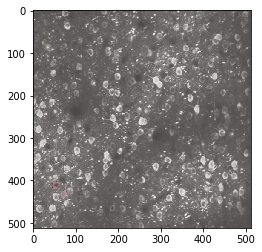

In [275]:
plt.imshow(max_projection, cmap='gray')
plt.imshow(two_rois, alpha=0.3, cmap='Reds')